In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from functools import partial
from random import uniform
rc('animation', html='jshtml')

In [2]:
# Cheryl's birthday example
num_x, num_y = 4, 6
eps = {'x': 1.5 / num_y, 'y': 1.5 / num_x}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 2.5 / num_x, 'y': 2.5 / num_y}

# store rectangles as [x_min, x_max, y_min, y_max]
rects = np.array([[0, 1 / num_x, 0, 1 / num_y],
                  [0, 1 / num_x, 3 / num_y, 5 / num_y],
                  [1 / num_x, 2 / num_x, 0, 3 / num_y],
                  [1 / num_x, 2 / num_x, 5 / num_y, 1],
                  [2 / num_x, 3 / num_x, 1 / num_y, 2 / num_y],
                  [2 / num_x, 3 / num_x, 3 / num_y, 1],
                  [3 / num_x, 1, 2 / num_y, 3 / num_y],
                  [3 / num_x, 1, 4 / num_y, 1]])

# limit to the bounded area
rects[:, :2] = np.clip(rects[:, :2], gl_bounds['x'][0], gl_bounds['x'][1])
rects[:, 2:] = np.clip(rects[:, 2:], gl_bounds['y'][0], gl_bounds['y'][1])

In [3]:
# # another example
# eps = {'x': 0.4, 'y': 0.4}
# true_coords = {'x': 0.4, 'y': 0.6}
# rects = np.array([[0, 0.5, 0, 0.5],
#                     [0, 1, 0.75, 1],
#                     [0.8, 1, 0, 0.2]])

In [4]:
grid = {'x': np.unique(np.concatenate([gl_bounds['x'], rects[:, 0], rects[:, 1]])), # np.unique sorts the values
        'y': np.unique(np.concatenate([gl_bounds['y'], rects[:, 2], rects[:, 3]]))}

# for animating we'll store on which step the cell became impossible
possible_cells = np.full((grid['y'].shape[0] - 1, grid['x'].shape[0] - 1), -1, dtype=int)

def mark_area_impossible(step, grid, possible_cells, rect):
    x_id = np.where(np.isclose(grid['x'], rect[0]))[0][0]
    y_id = np.where(np.isclose(grid['y'], rect[2]))[0][0]
    st_x_id = x_id
    has_changed = False
    while grid['y'][y_id] < rect[3]:
        while grid['x'][x_id] < rect[1]:
            if possible_cells[y_id, x_id] == -1:
                has_changed = True
                possible_cells[y_id, x_id] = step
            x_id += 1
        x_id = st_x_id
        y_id += 1
    return has_changed

for rect in rects:
    mark_area_impossible(0, grid, possible_cells, rect)
possible_cells

array([[ 0,  0, -1, -1],
       [-1,  0,  0, -1],
       [-1,  0, -1,  0],
       [ 0, -1,  0, -1],
       [ 0, -1,  0,  0],
       [-1,  0,  0,  0]])

In [5]:
# worlds for all other initially possible cells
other_worlds = []
true_cell_x, true_cell_y = np.searchsorted(grid['x'], true_coords['x']) - 1, \
                            np.searchsorted(grid['y'], true_coords['y']) - 1
print(true_cell_x, true_cell_y)
for x in range(grid['x'].shape[0] - 1):
    for y in range(grid['y'].shape[0] - 1):
        if x == true_cell_x and y == true_cell_y:
            continue
        if possible_cells[y, x] == -1:
            other_worlds.append([grid['x'][x] + (grid['x'][x + 1] - grid['x'][x]) / 2, \
                                 grid['y'][y] + (grid['y'][y + 1] - grid['y'][y]) / 2])

other_worlds = np.array(other_worlds)

2 2


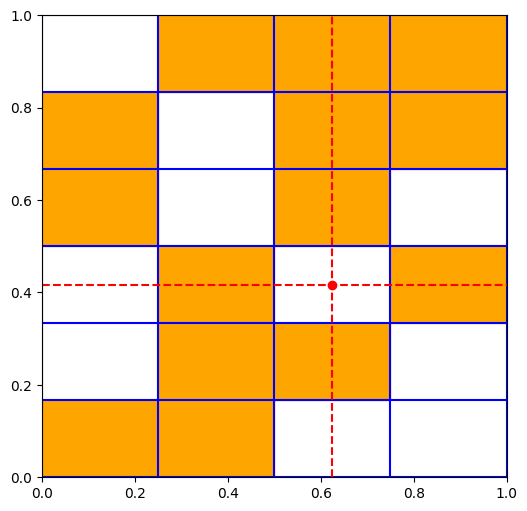

In [6]:
# draw grid, impossible areas and true coordinates
def draw(frame, ax, grid, possible_cells, true_coords, gl_bounds):
    ax.vlines(grid['x'], gl_bounds['y'][0], gl_bounds['y'][1], colors='blue')
    ax.hlines(grid['y'], gl_bounds['x'][0], gl_bounds['x'][1], colors='blue')

    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed')

    for row_id in range(possible_cells.shape[0]):
        for col_id in range(possible_cells.shape[1]):
            if possible_cells[row_id, col_id] == frame:
                x = [grid['x'][col_id], grid['x'][col_id], grid['x'][col_id + 1], grid['x'][col_id + 1]]
                y = [grid['y'][row_id], grid['y'][row_id + 1], grid['y'][row_id + 1], grid['y'][row_id]]
                ax.fill(x, y, color='orange')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])

fig, ax = plt.subplots(figsize=(6, 6))
draw(0, ax, grid, possible_cells, true_coords, gl_bounds)
# plt.show()

In [7]:
def is_smaller_eps(coord, axis, grid, possible_cells, eps, gl_bounds):
    # coord: float in [0, 1] - coord in axis
    # axis: 'x' or 'y'
    other_axis = 'x' if axis == 'y' else 'y'
    cell_id = np.searchsorted(grid[axis][:-1], coord, side='right') - 1 # index of corresponding column/row of cells
    first_avail, last_avail = None, None
    oa_idx = 0 if axis == 'x' else 1 # other axis id for possible_cells
    for i in range(possible_cells.shape[oa_idx]):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id] == -1:
            first_avail = i
            break
    for i in range(possible_cells.shape[oa_idx] - 1, -1, -1):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id] == -1:
            last_avail = i
            break
    if first_avail is None or last_avail is None:
        return False # no possible cells for that coordinate
    return grid[other_axis][last_avail + 1] - grid[other_axis][first_avail] < eps[axis]

In [8]:
def remove_impossible_areas(step, axis, remove_small, grid, possible_cells, true_coords, eps, gl_bounds):
    axis_idx = 0 if axis == 'y' else 1
    has_changed = False
    for cell_id in range(possible_cells.shape[axis_idx]):
        mid_coord = grid[axis][cell_id] + (grid[axis][cell_id + 1] - grid[axis][cell_id]) / 2
        if is_smaller_eps(mid_coord, axis, grid, possible_cells, eps, gl_bounds) == remove_small:
            rect = [gl_bounds['x'][0], gl_bounds['x'][1], grid['y'][cell_id], grid['y'][cell_id + 1]] if axis == 'y' \
                    else [grid['x'][cell_id], grid['x'][cell_id + 1], gl_bounds['y'][0], gl_bounds['y'][1]]
            has_changed_local = mark_area_impossible(step, grid, possible_cells, rect)
            has_changed = has_changed or has_changed_local

    return has_changed

In [9]:
def run_process(eps, gl_bounds, true_coords, grid, possible_cells):
    axis = 'x'
    does_know = {'x': False, 'y': False}
    has_changed_prev = True
    step = 1

    while not (does_know['x'] and does_know['y']):
        if is_smaller_eps(true_coords[axis], axis, grid, possible_cells, eps, gl_bounds):
            print(axis, "knows")
            does_know[axis] = True
            has_changed = remove_impossible_areas(step, axis, False, grid, possible_cells, true_coords, eps, gl_bounds)
        else:
            print(axis, "doesn't know")
            has_changed = remove_impossible_areas(step, axis, True, grid, possible_cells, true_coords, eps, gl_bounds)

        if not (has_changed_prev or has_changed):
            break
        has_changed_prev = has_changed
        axis = 'x' if axis == 'y' else 'y'
        step += 1
    return step

In [10]:
num_frames = run_process(eps, gl_bounds, true_coords, grid, possible_cells)

x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know


In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
anim = FuncAnimation(fig, partial(draw, ax=ax, grid=grid, possible_cells=possible_cells, \
                                  true_coords=true_coords, gl_bounds=gl_bounds), \
                     frames=num_frames, interval=700, repeat=False)
plt.close()
anim

In [12]:
def animate_multiple(frame, axs, nrows, ncols, grid, possible_cells_arr, worlds, gl_bounds):
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            true_coords = {'x': other_worlds[idx, 0], 'y': other_worlds[idx, 1]}
            draw(frame, axs[i, j], grid, possible_cells_arr[idx], true_coords, gl_bounds)
            idx += 1
            if idx >= worlds.shape[0]:
                return

In [13]:
nrows, ncols = 3, 3
# nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9))
possible_cells_arr = []
max_num_frames = 0

for i in range(other_worlds.shape[0]):
    possible_cells[possible_cells != 0] = -1
    coords = {'x': other_worlds[i, 0], 'y': other_worlds[i, 1]}
    print('true_coords', coords)
    num_frames = run_process(eps, gl_bounds, coords, grid, possible_cells)
    possible_cells_arr.append(np.copy(possible_cells))
    max_num_frames = max(num_frames, max_num_frames)

anim_mult = FuncAnimation(fig, partial(animate_multiple, axs=axs, nrows=nrows, ncols=ncols, grid=grid, \
                                       possible_cells_arr=possible_cells_arr, worlds=other_worlds, gl_bounds=gl_bounds), \
                            frames=max_num_frames, interval=700, repeat=False)
plt.close()
anim_mult

true_coords {'x': 0.125, 'y': 0.25}
x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know
true_coords {'x': 0.125, 'y': 0.41666666666666663}
x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know
true_coords {'x': 0.125, 'y': 0.9166666666666667}
x doesn't know
y knows
x knows
true_coords {'x': 0.375, 'y': 0.5833333333333333}
x doesn't know
y doesn't know
x knows
y knows
true_coords {'x': 0.375, 'y': 0.75}
x doesn't know
y knows
x knows
true_coords {'x': 0.625, 'y': 0.08333333333333333}
x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know
true_coords {'x': 0.875, 'y': 0.08333333333333333}
x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know
true_coords {'x': 0.875, 'y': 0.25}
x doesn't know
y doesn't know
x doesn't know
y doesn't know
x doesn't know
y doesn't know
true_coords {'x': 0.875, 'y': 0.5833333333333333}
x doesn't know
y doesn't know
x